In [25]:
import numpy as np
from collections import deque
from PIL import Image
import matplotlib.pyplot as plt

def extract_edges(matrix):
    """
    提取矩阵中的边缘像素，边缘像素是那些值为255且至少有一个邻居是0的像素。
    
    :param matrix: 原始图像的二值矩阵
    :return: 同样大小的矩阵，边缘像素为1，其他像素为0
    """
    rows, cols = matrix.shape
    # 创建一个与原始矩阵大小相同的全零矩阵
    edge_matrix = np.zeros((rows, cols), dtype=int)
    
    # 遍历矩阵中每个像素
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # 检查当前像素是否为255
            if matrix[i, j] == 255:
                # 检查上下左右是否有任意一个是0
                if (matrix[i-1, j] == 0 or matrix[i+1, j] == 0 or 
                    matrix[i, j-1] == 0 or matrix[i, j+1] == 0):
                    # 将边缘像素位置设置为1
                    edge_matrix[i, j] = 1
    
    return edge_matrix
  
def bfs_label(matrix, edge_result):
    """
    使用 BFS 对每个连通区域进行标记，生成一个与 edge_result 相同大小的标签矩阵。
    8邻域连通的像素点算作一个连通区域。
    
    :param matrix: 原始图像的二值矩阵
    :param edge_result: 边缘检测结果矩阵，边缘位置为 1，其余为 0
    :return: 标签矩阵，每个连通区域有唯一的标签
    """
    rows, cols = edge_result.shape
    label_matrix = np.zeros_like(edge_result, dtype=int)
    label = 1

    # 用于八个方向的移动
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    # 遍历每个像素，找到未标记的边缘像素
    for i in range(rows):
        for j in range(cols):
            if edge_result[i, j] == 1 and label_matrix[i, j] == 0:
                # 使用 BFS 对连通区域进行标记
                queue = deque([(i, j)])
                label_matrix[i, j] = label

                while queue:
                    x, y = queue.popleft()

                    # 检查八个方向的邻接像素
                    for dx, dy in directions:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < rows and 0 <= ny < cols:
                            if edge_result[nx, ny] == 1 and label_matrix[nx, ny] == 0:
                                label_matrix[nx, ny] = label
                                queue.append((nx, ny))

                label += 1

    return label_matrix

def enhance_edges(matrix, edge_result, label_matrix, max_value=2):
    """
    在原始图像中遍历每一个 edge_result 为 1 的位置，将8邻域相邻的像素值进行增强，
    并确保同一个连通区域仅贡献一次。
    
    :param matrix: 原始图像的二值矩阵
    :param edge_result: 边缘检测结果矩阵，边缘位置为 1，其余为 0
    :param label_matrix: 连通区域的标签矩阵
    :param max_value: 最大允许的增强值
    :return: 增强后的原始图像矩阵
    """
    rows, cols = matrix.shape
    contributions = {}  # map：记录每个像素的贡献情况，key：元组（坐标x，坐标y），value：set(label_No,...)

    # 遍历 edge_result 矩阵
    for i in range(rows):
        for j in range(cols):
            if edge_result[i, j] == 1:
                label = label_matrix[i, j]  # 当前边缘像素的连通区域标签

                # 检查八个方向的邻接像素
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                    ni, nj = i + dx, j + dy
                    if 0 <= ni < rows and 0 <= nj < cols:
                        if matrix[ni, nj] != 255:  # 只有背景像素才能被增强
                            # 初始化贡献记录
                            if (ni, nj) not in contributions:
                                contributions[(ni, nj)] = set()
                            # 检查是否已经被当前连通区域贡献过
                            if label not in contributions[(ni, nj)]:
                                contributions[(ni, nj)].add(label)
                                if matrix[ni, nj] < max_value:
                                    matrix[ni, nj] += 1
    
    return matrix, contributions

def set_values_to_max(matrix, min_value=1, max_value=255):
    """
    将矩阵中处于 min_value 和 max_value 之间的像素值设置为 max_value。
    
    :param matrix: 原始图像矩阵
    :param min_value: 最小阈值，默认值为 1
    :param max_value: 设置为的最大值，默认值为 255
    :return: 处理后的矩阵
    """
    # 创建一个布尔掩码，查找所有大于 min_value 小于 max_value 的值
    mask = (matrix > min_value) & (matrix < max_value)
    # 将这些值设置为 max_value
    matrix[mask] = max_value
    return matrix

def set_values_by_flag(matrix, flags, target_value):
    """
    根据标记数组 flags，将 matrix 中 flags 为 1 的位置设置为 target_value。
    
    :param matrix: 原始图像的二值矩阵
    :param flags: 标记数组，与 matrix 尺寸相同，1 表示需要修改的像素位置
    :param target_value: 需要设置的目标值
    :return: 修改后的矩阵
    """
    # 将 flags 为 1 的位置设置为 target_value
    matrix[flags == 1] = target_value
    return matrix

# 绘制原始矩阵和处理后的矩阵在一张图中
def save_combined_image(original_matrix, processed_matrix, save_path,save=False):
    """
    绘制原始矩阵和处理后的矩阵在一张图中并保存到指定路径。
    
    :param original_matrix: 原始图像矩阵
    :param processed_matrix: 处理后的图像矩阵
    :param save_path: 保存图像的路径
    """
    plt.figure(figsize=(12, 6))
    
    # 绘制原始矩阵
    plt.subplot(1, 2, 1)
    plt.imshow(original_matrix, cmap='gray')
    plt.title("Original Matrix")
    plt.axis('off')
    
    # 绘制处理后的矩阵
    plt.subplot(1, 2, 2)
    plt.imshow(processed_matrix, cmap='gray')
    plt.title("Processed Matrix")
    plt.axis('off')
    
    # 保存图像到指定路径
    if(save):
        plt.savefig(save_path)
        print(f"图像已保存到: {save_path}")
    else:
        plt.show()
    plt.close()

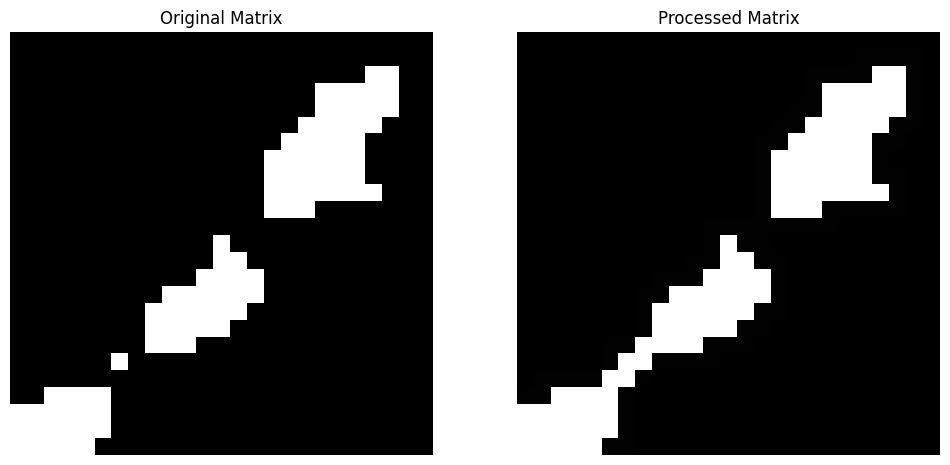

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   1   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
    1   1   1 255 255   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
  255 255 255 255 255   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1
  255 255 255 255 255   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1 255
  255 255 255 255   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1 255 255
  255 255 255   1   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1 255 255 255
  255 255 255   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1 255 255 255
  255 255 255   1   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  

In [22]:

# 原始图像矩阵
matrix_example = np.array([
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [   0,   0, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [ 255, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [ 255, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
    [ 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0 ],
])

edges = extract_edges(matrix_example)
labels = bfs_label(matrix_example,edges)

newMatrix = matrix_example.copy() # 复制原始矩阵
enhance,contributions =  enhance_edges(newMatrix, edges, labels)
ConnResult = set_values_to_max(enhance.copy())

# 示例使用
save_path = "/home/pxl/myProject/血管分割/molong-深度插值/molong-utils/combined_image.png"  # 指定保存路径
save_combined_image(matrix_example, ConnResult, save_path)

print(enhance)
print(labels)

# 提示图像已保存的路径

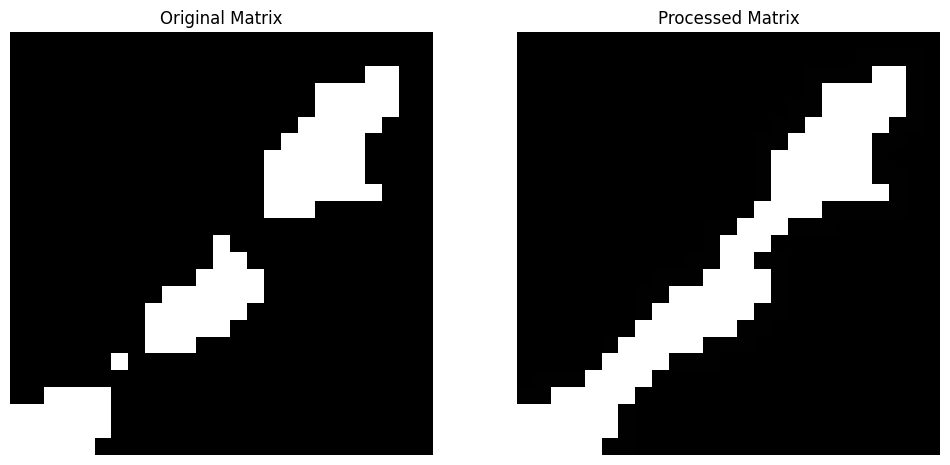

In [26]:
def mark_combined_contributions(contributions, matrix):
    """
    根据 contributions 中的记录，标记相邻像素由不同区域贡献的地方。
    
    :param contributions: 字典记录每个像素的贡献情况，key: (x, y), value: set(label_No,...)
    :param matrix_shape: 原始图像的尺寸 (rows, cols)
    :return: 新的标注数组，标记位置值为 1
    """
    # 初始化标记数组，大小和原始图像相同
    marked_array = np.zeros(matrix.shape, dtype=int)
    
    # 方向列表用于检查8邻域
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    # 遍历 contributions 中的每一个坐标点
    for (x, y), labels in contributions.items():
        # 如果当前坐标的 labels 集合中包含多个 label，说明已找到交集，跳过不参与邻近增强
        if len(labels) > 1:
            continue
        
        # 检查当前坐标的8邻域
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            # 判断邻域坐标是否在 contributions 中
            if (nx, ny) in contributions:
                # 检查邻域是否属于不同的 label
                if contributions[(nx, ny)].isdisjoint(labels):  # 确保没有交集
                    # 标记当前坐标和邻域坐标
                    marked_array[x, y] = 1
                    marked_array[nx, ny] = 1

    return marked_array



# print(contributions)
# print(enhance)
# 标记不同连通区域相连的增强点
flag = mark_combined_contributions(contributions, enhance)
# 打印结果
# print("标记后的结果矩阵:\n", marked_result)
enhance = set_values_by_flag(enhance,flag,3)
ConnResult = set_values_to_max(enhance.copy())

save_path = "/home/pxl/myProject/血管分割/molong-深度插值/molong-utils/combined_image.png"  # 指定保存路径
save_combined_image(matrix_example, ConnResult, save_path)
